### This is approach 1 using Logisitc Regression

In [8]:
# All the libraries that are needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [9]:
# Load the data
df = pd.read_csv('2021_August_hashtag_trend_data.csv')

# View the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

        trend_name                                      trend_url  \
0   #NRLManlyStorm   http://twitter.com/search?q=%23NRLManlyStorm   
1         #Boomers         http://twitter.com/search?q=%23Boomers   
2   #AFLCrowsPower   http://twitter.com/search?q=%23AFLCrowsPower   
3  #AFLSaintsSwans  http://twitter.com/search?q=%23AFLSaintsSwans   
4    #NeerajChopra    http://twitter.com/search?q=%23NeerajChopra   

         trend_query  tweet_volume        searched_at_datetime  \
0   %23NRLManlyStorm           NaN  2021-08-07 12:16:10.089293   
1         %23Boomers           NaN  2021-08-07 12:16:10.089293   
2   %23AFLCrowsPower           NaN  2021-08-07 12:16:10.089293   
3  %23AFLSaintsSwans           NaN  2021-08-07 12:16:10.089293   
4    %23NeerajChopra      109712.0  2021-08-07 12:16:10.089293   

  searched_in_country  
0           Australia  
1           Australia  
2           Australia  
3           Australia  
4           Australia  
trend_name                0
trend_url       

In [10]:
df.head(10)

,trend_name,trend_url,trend_query,tweet_volume,searched_at_datetime,searched_in_country
0,#NRLManlyStorm,http://twitter.com/search?q=%23NRLManlyStorm,%23NRLManlyStorm,NaN,2021-08-07 12:16:10.089293,Australia
1,#Boomers,http://twitter.com/search?q=%23Boomers,%23Boomers,NaN,2021-08-07 12:16:10.089293,Australia
2,#AFLCrowsPower,http://twitter.com/search?q=%23AFLCrowsPower,%23AFLCrowsPower,NaN,2021-08-07 12:16:10.089293,Australia
3,#AFLSaintsSwans,http://twitter.com/search?q=%23AFLSaintsSwans,%23AFLSaintsSwans,NaN,2021-08-07 12:16:10.089293,Australia
4,#NeerajChopra,http://twitter.com/search?q=%23NeerajChopra,%23NeerajChopra,109712.0,2021-08-07 12:16:10.089293,Australia
5,#NRLRoostersPanthers,http://twitter.com/search?q=%23NRLRoostersPant...,%23NRLRoostersPanthers,NaN,2021-08-07 12:16:10.089293,Australia
6,#weflyasone,http://twitter.com/search?q=%23weflyasone,%23weflyasone,NaN,2021-08-07 12:16:10.089293,Australia
7,#afltigersnorth,http://twitter.com/search?q=%23afltigersnorth,%23afltigersnorth,NaN,2021-08-07 12:16:10.089293,Australia
8,#bloods,http://twitter.com/search?q=%23bloods,%23bloods,NaN,2021-08-07 12:16:10.089293,Australia
9,#FlicksNoChills,http://twitter.com/search?q=%23FlicksNoChills,%23FlicksNoChills,NaN,2021-08-07 12:16:10.089293,Australia


In [11]:
df['tweet_volume'].fillna(0, inplace=True)

<ipython-input-11-68a68b4685e5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tweet_volume'].fillna(0, inplace=True)


In [12]:
df['tweet_volume'] = df['tweet_volume'].astype(float)

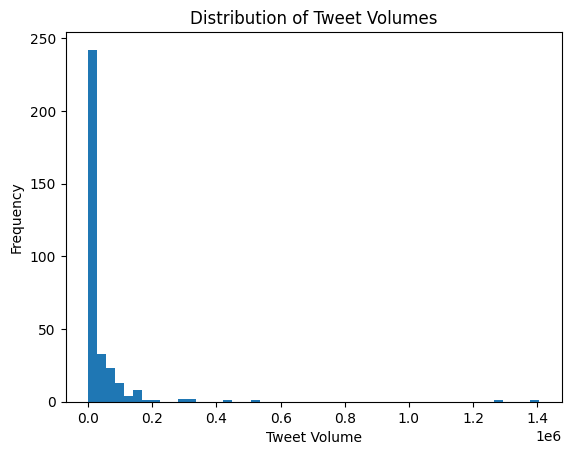

Threshold: 88730.0


In [13]:
# Visualize the distribution of tweet volumes
plt.hist(df['tweet_volume'], bins=50)
plt.xlabel('Tweet Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Volumes')
plt.show()

# Set threshold at 90th percentile
threshold = df['tweet_volume'].quantile(0.9)
print('Threshold:', threshold)

# Create target variable
df['is_viral'] = np.where(df['tweet_volume'] >= threshold, 1, 0)

In [14]:
# Convert searched_at_datetime to datetime and extract features
df['searched_at_datetime'] = pd.to_datetime(df['searched_at_datetime'])
df['hour'] = df['searched_at_datetime'].dt.hour
df['day'] = df['searched_at_datetime'].dt.day
df['month'] = df['searched_at_datetime'].dt.month
df['weekday'] = df['searched_at_datetime'].dt.weekday

In [15]:
X = df[['trend_name', 'hour', 'day', 'month', 'weekday']]
y = df['is_viral']

In [16]:
# Define preprocessing for different feature types
text_features = ['trend_name']
numeric_features = ['hour', 'day', 'month', 'weekday']

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'trend_name'),
        ('num', StandardScaler(), ['hour', 'day', 'month', 'weekday'])
    ]
)

In [17]:
# Create pipeline with Logistic Regression
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Logistic Regression Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_lr))
print('Logistic Regression ROC AUC Score:', roc_auc_score(y_test, model_lr.predict_proba(X_test)[:, 1]))

Logistic Regression Accuracy: 0.8955223880597015
Logistic Regression Confusion Matrix:
 [[60  0]
 [ 7  0]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94        60
           1       0.00      0.00      0.00         7

    accuracy                           0.90        67
   macro avg       0.45      0.50      0.47        67
weighted avg       0.80      0.90      0.85        67

Logistic Regression ROC AUC Score: 0.9773809523809525


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
X_train.head()

,trend_name,hour,day,month,weekday
224,#GodFather,12,21,8,5
78,#SuperLeague,12,7,8,5
295,#CityArs,12,28,8,5
17,#aflbluessuns,12,7,8,5
24,#CANWNT,12,7,8,5


In [19]:
# Use the best model for predictions
best_model = model_lr
y_pred_best = best_model.predict(X_test)
print('Best Model Accuracy:', accuracy_score(y_test, y_pred_best))

Best Model Accuracy: 0.8955223880597015


In [20]:
now = datetime.now()

In [30]:
def predict_viral_probability(hashtag):


  if not isinstance(hashtag, str):
    raise ValueError("Hashtag must be a string.")

  month_name = now.strftime('%B')

  # Map month names to numbers
  month_map = {
      'January': 1, 'February': 2, 'March': 3, 'April': 4,
      'May': 5, 'June': 6, 'July': 7, 'August': 8,
      'September': 9, 'October': 10, 'November': 11, 'December': 12
  }

  # Get the numeric representation of the current month
  month = month_map.get(month_name)

  weekday_name = now.strftime('%A')
  weekday_map = {
      'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
      'Friday': 4, 'Saturday': 5, 'Sunday': 6
  }
  weekday = weekday_map.get(weekday_name)

  new_data = pd.DataFrame({
      'trend_name': [hashtag],
      'hour': [now.hour],
      'day': [now.day],
      'month': [month],
      'weekday': [weekday]
  })
  probability = best_model.predict_proba(new_data)[:, 1]
  return probability[0]

# Example usage
prob = predict_viral_probability('#BiharTeachersAppointment')
print(f'Probability of going viral: {prob:.2f}')

Probability of going viral: 0.19


In [22]:
# Save the model

joblib.dump(best_model, 'twitter_hashtag_predictor_0.1v.pkl')

['twitter_hashtag_predictor_0.1v.pkl']

In [33]:
m2 = joblib.load('twitter_hashtag_predictor_0.1v.pkl')

# Assuming 'now' represents the current datetime
now = datetime.now()

def predict_single_hashtag(hashtag, model=m2, current_datetime=now):
    """Predicts the virality of a single hashtag.

    Args:
        hashtag (str): The hashtag to predict.
        model (Pipeline, optional): The trained model. Defaults to m2.
        current_datetime (datetime, optional): The current datetime. Defaults to now.

    Returns:
        int: 0 if not viral, 1 if viral.
    """

    month_name = current_datetime.strftime('%B')
    weekday_name = current_datetime.strftime('%A')

    # Map month names to numbers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    # Map weekdays to numbers
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }

    month = month_map.get(month_name)
    weekday = weekday_map.get(weekday_name)


    # Create a DataFrame with the necessary columns
    new_data = pd.DataFrame({
        'trend_name': [hashtag],
        'hour': [current_datetime.hour],
        'day': [current_datetime.day],
        'month': [month],
        'weekday': [weekday]
    })

    # Make the prediction
    prediction = m2.predict_proba(new_data)[:, 1]

    return prediction[0]  # Return the prediction (0 or 1)


# Example usage:
pred = predict_single_hashtag('#save')
print(f'Probability of going viral: {pred:.2f}')

Probability of going viral: 0.09


In [ ]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.utils import resample
# from datetime import datetime
# import joblib

# # Load the data
# df = pd.read_csv('2021_August_hashtag_trend_data.csv')

# # Fill missing values and clean data
# df['tweet_volume'].fillna(0, inplace=True)
# df['tweet_volume'] = df['tweet_volume'].astype(float)

# # Create target variable
# threshold = df['tweet_volume'].quantile(0.9)
# df['is_viral'] = np.where(df['tweet_volume'] >= threshold, 1, 0)

# # Convert datetime and extract features
# df['searched_at_datetime'] = pd.to_datetime(df['searched_at_datetime'])
# df['hour'] = df['searched_at_datetime'].dt.hour
# df['day'] = df['searched_at_datetime'].dt.day
# df['month'] = df['searched_at_datetime'].dt.month
# df['weekday'] = df['searched_at_datetime'].dt.weekday

# # Balance the dataset
# df_majority = df[df['is_viral'] == 0]
# df_minority = df[df['is_viral'] == 1]
# df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
# df_balanced = pd.concat([df_majority, df_minority_upsampled])

# # Define features and target
# X = df_balanced[['trend_name', 'hour', 'day', 'month', 'weekday']]
# y = df_balanced['is_viral']

# # Preprocessing for text and numeric features
# text_features = 'trend_name'
# numeric_features = ['hour', 'day', 'month', 'weekday']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('tfidf', TfidfVectorizer(max_features=5000), text_features),
#         ('num', StandardScaler(), numeric_features)
#     ]
# )

# # Use Gradient Boosting Classifier
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42))
# ])

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:, 1]

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
# print('Classification Report:\n', classification_report(y_test, y_pred))
# print('ROC AUC Score:', roc_auc_score(y_test, y_proba))

# # Save the model
# joblib.dump(model, 'powerful_twitter_hashtag_predictor.pkl')

# # Function to predict viral probability
# now = datetime.now()

# def predict_viral_probability(hashtag):
#     """
#     Predict the probability of a hashtag going viral.

#     Parameters:
#         hashtag (str): The hashtag to predict for.

#     Returns:
#         float: Probability of the hashtag going viral.
#     """
#     if not isinstance(hashtag, str):
#         raise ValueError("Hashtag must be a string.")

#     # Extract the current time features
#     now = datetime.now()
#     month_name = now.strftime('%B')
#     weekday_name = now.strftime('%A')

#     # Map month names to numbers
#     month_map = {
#         'January': 1, 'February': 2, 'March': 3, 'April': 4,
#         'May': 5, 'June': 6, 'July': 7, 'August': 8,
#         'September': 9, 'October': 10, 'November': 11, 'December': 12
#     }
#     # Map weekdays to numbers
#     weekday_map = {
#         'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
#         'Friday': 4, 'Saturday': 5, 'Sunday': 6
#     }

#     month = month_map.get(month_name)
#     weekday = weekday_map.get(weekday_name)

#     # Create a DataFrame for the input
#     new_data = pd.DataFrame({
#         'trend_name': [hashtag],
#         'hour': [now.hour],
#         'day': [now.day],
#         'month': [month],
#         'weekday': [weekday]
#     })

#     # Use the pipeline for prediction to ensure consistent preprocessing
#     probability = best_model.predict_proba(new_data)[:, 1]
#     return probability[0]

# # Example usage
# prob = predict_viral_probability('#savetheforest')
# print(f'Probability of going viral: {prob:.2f}')
